# Run the Force-directed Structure Generator
Use a simple algorithm and see how we do

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.inversion.force import convert_directed_graph_to_xyz
from hydronet.inversion import evaluate_inversion
from hydronet.data import atoms_from_dict
from scipy.stats import kendalltau
from random import choices
from tqdm import tqdm
import pandas as pd
import json

## Perform the analysis on all structures.
Take the known geometry, make the graph, invert the graph and report how different the new geometry is

In [2]:
results = []
with open('../benchmark_clusters.json') as fp:
    lines = fp.readlines()
    for line in tqdm(lines):
        record = json.loads(line)
        result = evaluate_inversion(convert_directed_graph_to_xyz, atoms_from_dict(record))        
        record.update(result)
        results.append(record)

100%|██████████| 2270/2270 [55:03<00:00,  1.46s/it]


In [3]:
results = pd.DataFrame(results)
results.head()

,z,n_water,n_atoms,atom,coords,energy,source,invert_time,unrelaxed_energy,relax_time,total_time,final_energy,energy_diff,is_isometric,adj_difference,rmsd
0,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[16.22398533, 11.83660939, -10.64692684], [16...",-236.543072,best,0.012961,126.464285,1.272933,1.285894,-229.544021,6.999051,False,6,180.111629
1,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-4.89073277, -6.3163085, 5.12766981], [-4.28...",-236.547806,best,0.013387,55.740522,0.951945,0.965331,-236.547287,0.000524,True,0,82.021126
2,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-2.35686894, -4.33661624, 6.51201207], [-2.4...",-236.561279,best,0.013208,-3.756672,1.150333,1.163541,-228.472522,8.088757,False,6,66.919179
3,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[15.43519603, 3.81546594, -16.89504925], [15....",-236.572013,best,0.013173,33.033412,1.418596,1.431769,-235.188667,1.383345,False,2,186.778202
4,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-3.52119126, -1.80291181, -1.00666364], [-4....",-236.574054,best,0.013383,-50.496505,1.370497,1.383880,-228.335074,8.238980,False,2,33.627474


Save the results. Note that I'm excluding the coordinates of the original structure, which are no longer needed

In [4]:
results.drop(columns=['z', 'atom', 'coords']).to_csv('force-directed.csv', index=False)

## Assess the Results
I want to see how often we get the 'correct' graph or one that is energetically degenerate under different conditions

## How different are the graphs?
See if we recover the initial graph exactly and, if not, how many bonds are missing.

In [5]:
print(f'Overall isometric success rate: {results["is_isometric"].mean()*100:.1f}%')

Overall isometric success rate: 26.2%


See by system size

Text(0.5, 0, 'Cluster Size')

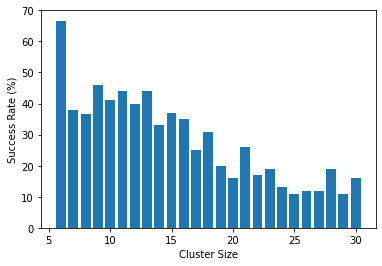

In [6]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['is_isometric'].mean()
ax.bar(by_size.index, by_size * 100)

ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Cluster Size')

Success rate is not great. We achieve a rate of <30% for large clusters.

Text(0.5, 0, 'Cluster Size')

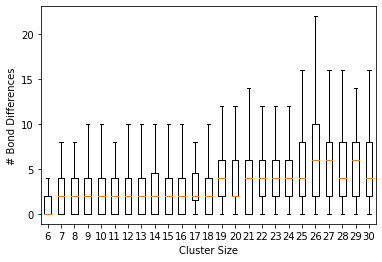

In [7]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['adj_difference'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('# Bond Differences')
ax.set_xlabel('Cluster Size')

## How large are the energy differences? 
Are they large in absolute magnitude? Large enough to interfere with ranking

Text(0.5, 0, 'Cluster Size')

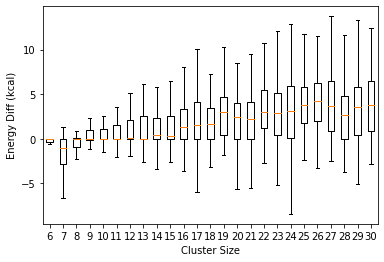

In [8]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['energy_diff'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('Energy Diff (kcal)')
ax.set_xlabel('Cluster Size')

Energy difference can be quite large and are easily in the ~0.1 kcal/water range.

Measure ranking performance with Kendal tau

In [9]:
results['new_energy'] = results['energy'] + results['energy_diff']

Text(0.5, 0, 'Cluster Size')

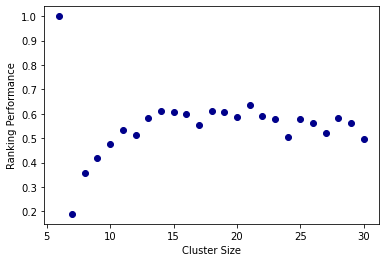

In [10]:
fig, ax = plt.subplots()

for size, group in results.groupby('n_water'):
    rank_val = kendalltau(group['energy'], group['new_energy'])
    ax.scatter([size], [rank_val.correlation], color='darkblue')

ax.set_ylabel('Ranking Performance')
ax.set_xlabel('Cluster Size')

The ranking performance is better than random, but not great. It seems that we expect 50% of pairs to be in the correct order.